# The Simpsons

## Preparations

### Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [117]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import itertools
import glob
from sklearn import preprocessing, metrics

In [118]:
import warnings

#warnings.filterwarnings('ignore')

### Select Characters

Create a list of characters that we want to recognise

In [119]:
characters = [
    # "abraham_grampa_simpson", not same images
    # "agnes_skinner", only ~50 images
    "apu_nahasapeemapetilon",
    # "barney_gumble", only ~100 images
    "bart_simpson",
    # "carl_carlson", only ~100 images
    "charles_montgomery_burns",
    "chief_wiggum",
    # "cletus_spuckler", only ~50 images
    # "comic_book_guy", great confusion
    # "disco_stu", only 8 (!) images
    "edna_krabappel",
    # "fat_tony", only ~30 images
    # "gil", only ~30 images
    #"groundskeeper_willie", only ~120 images
    "homer_simpson",
    "kent_brockman",
    "krusty_the_clown",
    # "lenny_leonard", great confusion
    # "lionel_hutz", only 3 (!!!) images
    "lisa_simpson",
    # "maggie_simpson", only ~120 images
    "marge_simpson",
    # "martin_prince", only ~120 images
    # "mayor_quimby", only ~250 images
    "milhouse_van_houten",
    # "miss_hoover", only ~20 images
    "moe_szyslak",
    "ned_flanders",
    # "nelson_muntz", great confusion
    # "otto_mann", only ~30 images
    # "patty_bouvier", only ~70 images
    "principal_skinner",
    # "professor_john_frink", only ~70 images
    # "rainier_wolfcastle", only ~50 images
    # "ralph_wiggum", only ~90 images
    # "selma_bouvier", only ~100 images
    "sideshow_bob",
    # "sideshow_mel", only ~40 images
    # "snake_jailbird", only ~50 images
    # "troy_mcclure", only 8 (!) images
    # "waylon_smithers", only ~180 images
]

In [120]:
#Randomly pick characters for testing
import random

number_of_characters = len(characters)

selected_characters = random.sample(characters, number_of_characters)
print(selected_characters)

['ned_flanders', 'sideshow_bob', 'principal_skinner', 'edna_krabappel', 'chief_wiggum', 'moe_szyslak', 'milhouse_van_houten', 'lisa_simpson', 'kent_brockman', 'krusty_the_clown', 'homer_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'marge_simpson']


## Labeling for CNN

In [121]:
encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)

LabelEncoder()

### Directories

In [122]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Previewing the characters

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'ned_flanders')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'sideshow_bob')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'principal_skinner')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'edna_krabappel')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'chief_wiggum')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'moe_szyslak')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'milhouse_van_houten')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'lisa_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'kent_brockman')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'krusty_the_clown')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'homer_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'bart_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'apu_nahasapeemapetilon')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'charles_montgomery_burns')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'marge_simpson')

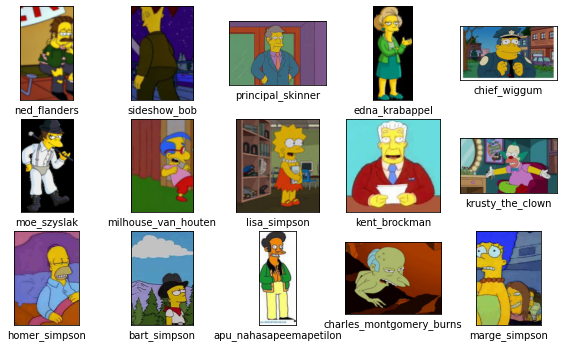

In [123]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
plt.show()

## Resizing Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [124]:
standard_resolution = 352
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

In [125]:
def get_resized_image(image_path):
    img = Image.open(image_path)
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)  #store im as numpy array
    # shape of image is ([128x(r,g,b)], [128x(r,g,b)])
    img = np.array(img)
    return img

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'ned_flanders')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'sideshow_bob')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'principal_skinner')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'edna_krabappel')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'chief_wiggum')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'moe_szyslak')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'milhouse_van_houten')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'lisa_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'kent_brockman')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'krusty_the_clown')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'homer_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'bart_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'apu_nahasapeemapetilon')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'charles_montgomery_burns')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'marge_simpson')

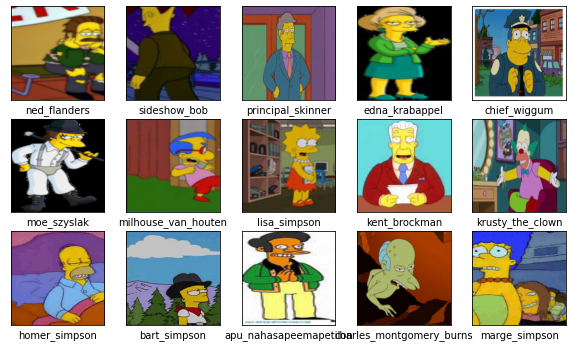

In [126]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(get_resized_image(directories["dataset"] + character_name + "/pic_0000.jpg"))
    plt.xlabel(character_name)
plt.show()

## Load files and split into test data

In [127]:
test_factor = 0.17  # determine what percentage of each character's images should be used for testing

In [128]:
print(selected_characters)

['ned_flanders', 'sideshow_bob', 'principal_skinner', 'edna_krabappel', 'chief_wiggum', 'moe_szyslak', 'milhouse_van_houten', 'lisa_simpson', 'kent_brockman', 'krusty_the_clown', 'homer_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'marge_simpson']
6


In [129]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  #loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_test_count = round(current_character_picture_count * test_factor)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0
    current_breakpoint = current_character_picture_count*test_factor

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(
            current_character_paths_list):  #loop over all files ending in .jpg in the current folder
        print("[", current_image_position, "/", current_character_picture_count, "]" + current_character_picture_path,
              end='\r')

        current_character_picture = get_resized_image(current_character_picture_path)  # load picture
        rand_int = random.randint(1,current_character_picture_count) #random factor to decide if picture is training or test data
        if rand_int <= current_breakpoint:  
            test_images.append(current_character_picture)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(current_character_picture)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:ned_flanders (label number 12)

[ 1453 / 1454 ]./data/archive/simpsons_dataset/ned_flanders/pic_0333.jpg./data/archive/simpsons_dataset/ned_flanders/pic_0332.jpg/ 1454 ]./data/archive/simpsons_dataset/ned_flanders/pic_0469.jpg934 / 1454 ]./data/archive/simpsons_dataset/ned_flanders/pic_1155.jpg 1454 ]./data/archive/simpsons_dataset/ned_flanders/pic_1212.jpg
Loading Character:sideshow_bob (label number 14)

[ 876 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0333.jpg
Loading Character:principal_skinner (label number 13)

[ 1193 / 1194 ]./data/archive/simpsons_dataset/principal_skinner/pic_0333.jpg
Loading Character:edna_krabappel (label number 4)

[ 456 / 457 ]./data/archive/simpsons_dataset/edna_krabappel/pic_0333.jpg386 / 457 ]./data/archive/simpsons_dataset/edna_krabappel/pic_0049.jpg
Loading Character:chief_wiggum (label number 3)

[ 985 / 986 ]./data/archive/simpsons_dataset/chief_wiggum/pic_0333.jpg986 ]./data/archive/simpsons_dataset/chief_wiggum/pic_0

In [130]:
training_images[0].shape
len(training_images)
len(test_images)

(352, 352, 3)

14398

2854

## Create Convolutional Neuronal Network

In [131]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(standard_resolution, standard_resolution, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(selected_characters), activation='relu')
])

In [132]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 352, 352, 3)       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 352, 352, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 352, 352, 8)       224       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 176, 176, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 176, 176, 16)      1168      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 88, 88, 32)       

In [133]:
#from sklearn.preprocessing import LabelEncoder

#df[target_col] = LabelEncoder().fit_transform(df[target_col])

In [134]:
#training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

Epoch 1/20
450/450 [==============================] - 348s 771ms/step - loss: 2.1301 - accuracy: 0.3406 - val_loss: 1.7618 - val_accuracy: 0.4723
Epoch 2/20
450/450 [==============================] - 347s 772ms/step - loss: 1.5740 - accuracy: 0.5283 - val_loss: 1.4386 - val_accuracy: 0.5708
Epoch 3/20
450/450 [==============================] - 346s 769ms/step - loss: 1.3213 - accuracy: 0.6036 - val_loss: 1.3153 - val_accuracy: 0.6062
Epoch 4/20
450/450 [==============================] - 341s 757ms/step - loss: 1.1599 - accuracy: 0.6441 - val_loss: 1.2506 - val_accuracy: 0.6282
Epoch 5/20
450/450 [==============================] - 342s 761ms/step - loss: 1.0633 - accuracy: 0.6734 - val_loss: 1.2123 - val_accuracy: 0.6359
Epoch 6/20
450/450 [==============================] - 348s 773ms/step - loss: 0.9777 - accuracy: 0.6947 - val_loss: 1.1529 - val_accuracy: 0.6573
Epoch 7/20
450/450 [==============================] - 348s 774ms/step - loss: 0.8967 - accuracy: 0.7170 - val_loss: 1.1590 -

## Export model

In [135]:
model.save_weights('./models/simpsons')

## Visualise the Network

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

(0.0, 1.0)

90/90 - 18s - loss: 1.1656 - accuracy: 0.6927


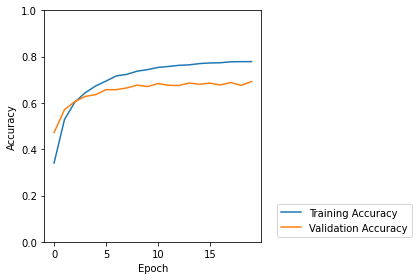

In [136]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

(0.0, 2.0)

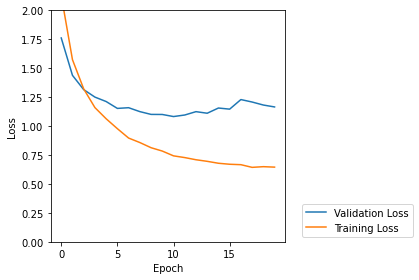

In [137]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

## Load the test dataset

In [138]:
def load_test_set():
    pics, labels = [], []
    for all_test_pictures in glob.glob(directories["testset"] + '*.jpg'):
        file_name = all_test_pictures.split("/")[
            -1]  # './data/archive/kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_34.jpg'
        character_name_with_number = file_name.split(".jpg")[-2]  # 'principal_skinner_34'
        character_name_clean = character_name_with_number.rsplit('_', 1)[0]  # 'principal_skinner'

        if character_name_clean in selected_characters:
            character_label = encoded_labels.transform([character_name_clean])
            temp = get_resized_image(all_test_pictures)
            pics.append(temp)
            labels.append(character_label)
    x_test = np.array(pics)
    y_test = np.array(labels)
    print("Test set", x_test.shape, y_test.shape)
    return x_test, y_test

In [139]:
x_test, y_test = load_test_set()
prediction = model.predict(x_test)

Test set (743, 352, 352, 3) (743, 1)


## Confusion Matrix

<Figure size 720x720 with 0 Axes>

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

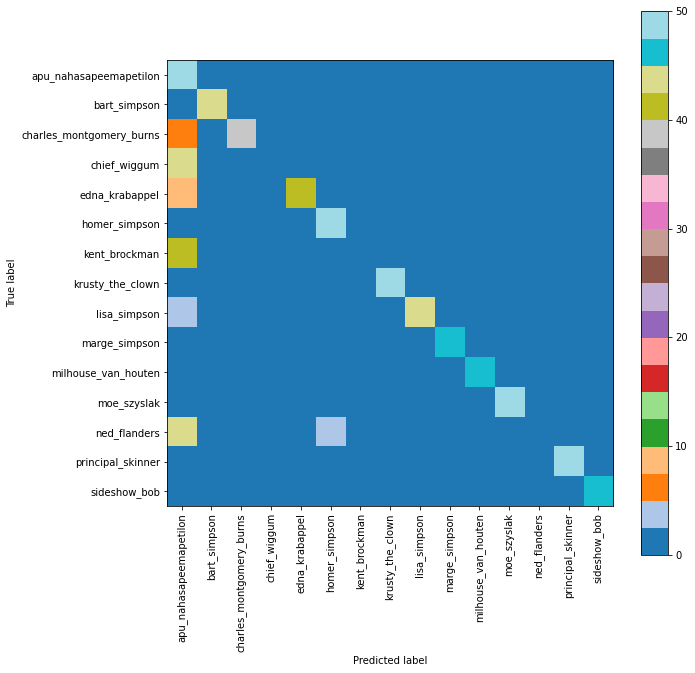

In [140]:
plt.figure(figsize=(10, 10))
labels = list(encoded_labels.classes_)
cm = metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
tick_marks = np.arange(len(labels))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20)
plt.colorbar()
_ = plt.xticks(tick_marks, labels, rotation=90)
_ = plt.yticks(tick_marks, labels)
plt.savefig("confusion_matrix.png", dpi=300)
#p = metrics.ConfusionMatrixDisplay(cm, display_labels=labels).plot()

## Simple Predictions

In [141]:
prediction_images = []

random_choice = random.choice(selected_characters)
random_number = random.randint(0,30)

current_character_picture = get_resized_image(directories["testset"] + random_choice + "_" + str(random_number) + ".jpg")

#im = current_character_picture / 255.0
#img_array = tf.expand_dims(im, 0)  # Create a batch

img_array = tf.expand_dims(current_character_picture, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

#print(predictions[0])
#print(score)

#print(100 * np.max(score))

#print(np.argmax(predictions))
#print([labels[i] for i,prob in enumerate(predictions) if prob > 0.5])
print("Randomly chosen character: " + random_choice)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
)

Randomly chosen character: apu_nahasapeemapetilon
This image most likely belongs to apu_nahasapeemapetilon with a 99.94 percent confidence.
